In [11]:
import numpy as np
import cv2
import torch
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors


In [12]:
T = 30
HIP_JOINT = 11
DIST_THRESH = 80
MAX_MISS = 10
EPS = 1e-6


In [13]:
ANGLE_TRIPLETS = [
    (5, 7, 9),     # left arm
    (6, 8, 10),    # right arm
    (11, 13, 15),  # left leg
    (12, 14, 16),  # right leg
    (5, 11, 13),   # left torso-leg
    (6, 12, 14),   # right torso-leg
]


In [14]:
def joint_angle(a, b, c):
    ba = a - b
    bc = c - b
    cos = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + EPS)
    return np.arccos(np.clip(cos, -1, 1))


In [15]:
def extract_angle_feature(pose_seq):
    """
    pose_seq: (3,T,17)
    return: (D,)
    """
    xy = pose_seq[:2].transpose(1, 2, 0)  # (T,17,2)
    angles = []

    for t in range(T):
        frame_angles = []
        for i, j, k in ANGLE_TRIPLETS:
            frame_angles.append(
                joint_angle(xy[t, i], xy[t, j], xy[t, k])
            )
        angles.append(frame_angles)

    angles = np.array(angles)  # (T, A)

    feat = np.concatenate([
        angles.mean(axis=0),
        angles.std(axis=0),
    ])
    return feat


In [16]:
def mahalanobis_score(x, mu, inv_cov):
    diff = x - mu
    dist = np.sqrt(diff @ inv_cov @ diff.T)
    score = np.exp(-dist)
    return score, dist


In [17]:
import pandas as pd

df = pd.read_csv("cleaned_pose_data.csv")
df.head()

,video_name,frame_id,person_id,joint_id,x,y,score
0,Hoang_Hearn,0,0,0,257.707092,629.240845,0.171782
1,Hoang_Hearn,0,0,1,260.629639,621.918457,0.159820
2,Hoang_Hearn,0,0,2,258.474365,621.872253,0.032368
3,Hoang_Hearn,0,0,3,264.950623,621.193115,0.924104
4,Hoang_Hearn,0,0,4,286.588562,618.743774,0.355051


In [18]:
label_to_video = {0: 'Hoang_Hearn',
                  1: 'Kum_Pa_Gun_Poong_Hork',
                  2: 'Mek_Khara_Lor_Kaew',
                  3: 'Narai_Kwang_Jug',
                  4: 'Phra_Ram_Phang_Sorn',
                  5: 'Tad_Mai_Khom_Nam'}

In [19]:
video_to_label = {'Hoang_Hearn': 0,
                  'Kum_Pa_Gun_Poong_Hork': 1,
                  'Mek_Khara_Lor_Kaew': 2,
                  'Narai_Kwang_Jug': 3,
                  'Phra_Ram_Phang_Sorn': 4,
                  'Tad_Mai_Khom_Nam': 5}

In [20]:
from collections import defaultdict
import numpy as np

T = 30
NUM_JOINTS = 17
HIP_JOINT = 11

train_sequences = defaultdict(list)

groups = df.groupby(["video_name", "person_id"])

for (video_name, person_id), g in groups:

    if video_name not in video_to_label:
        continue

    label = video_to_label[video_name]   # int label

    g = g.sort_values("frame_id")
    frame_ids = g["frame_id"].unique()

    for start in range(0, len(frame_ids) - T + 1, T):

        frames = frame_ids[start:start + T]
        pose_seq = np.zeros((3, T, NUM_JOINTS), dtype=np.float32)

        for t, fid in enumerate(frames):
            frame_data = g[g.frame_id == fid]
            for row in frame_data.itertuples():
                j = row.joint_id
                pose_seq[0, t, j] = row.x
                pose_seq[1, t, j] = row.y
                pose_seq[2, t, j] = row.score

        # normalize hip (same as train)
        hip = pose_seq[:2, :, HIP_JOINT:HIP_JOINT+1]
        pose_seq[:2] -= hip

        train_sequences[label].append(pose_seq)


In [21]:
for action, seqs in train_sequences.items():
    print(action, len(seqs), seqs[0].shape)
    

0 216 (3, 30, 17)
1 234 (3, 30, 17)
2 135 (3, 30, 17)
3 242 (3, 30, 17)
4 171 (3, 30, 17)
5 99 (3, 30, 17)


In [22]:
features = {}

for label, seqs in train_sequences.items():
    feats = [extract_angle_feature(seq) for seq in seqs]
    if len(feats) >= 5:   # guard
        features[label] = np.stack(feats)


In [23]:
maha_models = {}

for label, X in features.items():
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False) + 1e-5 * np.eye(X.shape[1])
    inv_cov = np.linalg.inv(cov)
    maha_models[label] = (mu, inv_cov)


In [24]:
import torch
import torch.nn as nn

# ---------- Graph Convolution ----------
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.A = nn.Parameter(
            torch.tensor(A, dtype=torch.float32),
            requires_grad=False
        )  # (K, V, V)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (N*M, C, T, V)
        A = self.A.to(x.device)
        x = torch.einsum("nctv,kvw->nctw", x, A)
        x = self.conv(x)
        return x


# ---------- ST-GCN Block ----------
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, dropout=0.0):
        super().__init__()

        self.gcn = GraphConv(in_channels, out_channels, A)

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),
                padding=(4, 0),
                stride=(stride, 1)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout)   # dropout อยู่ตรงนี้
        )

        # residual
        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        return self.relu(x + res)


# ---------- ST-GCN Model ----------
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, A):
        super().__init__()

        self.layer1 = STGCNBlock(in_channels, 64,  A, stride=1, dropout=0.1)
        self.layer2 = STGCNBlock(64, 128, A, stride=2, dropout=0.3)
        self.layer3 = STGCNBlock(128, 256, A, stride=2, dropout=0.3)

        self.dropout = nn.Dropout(0.5)  # ก่อน fc
        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.shape

        # -------- Input normalization (สำคัญมาก) --------
        x[:, 0:2] = x[:, 0:2] - x[:, 0:2].mean(dim=3, keepdim=True)
        x[:, 0:2] = x[:, 0:2] / (x[:, 0:2].std() + 1e-6)

        # flatten person
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        x = x.view(N * M, C, T, V)

        # ST-GCN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # global average pooling
        x = x.mean(dim=2).mean(dim=2)   # (N*M, C)

        # restore person
        x = x.view(N, M, -1).mean(dim=1)

        x = self.dropout(x)
        return self.fc(x)


In [25]:
data = torch.load("stgcn_dataset.pt", map_location="cpu")
A       = data["graph"]      # (3, V, V)

C:\Users\User\AppData\Local\Temp\ipykernel_23476\1797858249.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("stgcn_dataset.pt", map_location="cpu")


In [26]:
model = STGCN(
    in_channels=3,
    num_class=6,   # จาก label_to_video มี 6 class
    A=A            # adjacency matrix ตัวเดิม
)

C:\Users\User\AppData\Local\Temp\ipykernel_23476\4124120401.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(A, dtype=torch.float32),


In [27]:
device = next(model.parameters()).device
model_path = "stgcn_trained_v2.pt"
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [28]:
device = next(model.parameters()).device
model.eval()

cap = cv2.VideoCapture("muay_thai_clip.mp4")

person_buffers = defaultdict(list)
person_centers = {}
person_last_pred = {}
person_miss = {}

next_person_id = 0


In [29]:
from ultralytics import YOLO

pose_model = YOLO("yolov8l-pose.pt")


In [30]:
SKELETON = [
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 6),
    (5, 11), (6, 12),
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
]

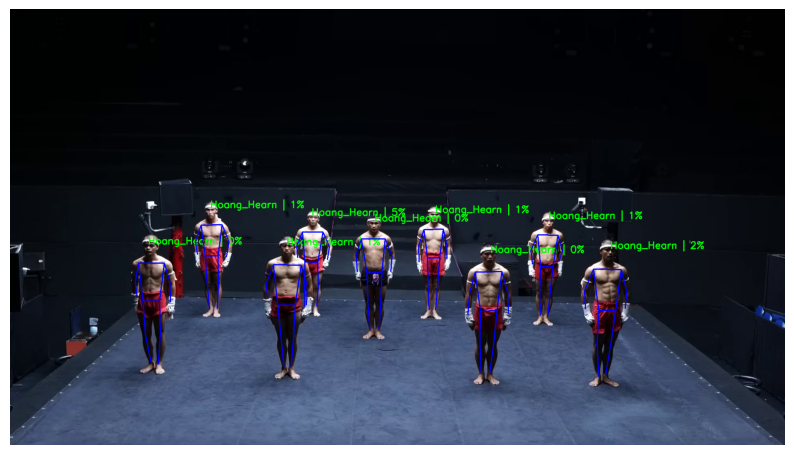

In [31]:
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

device = next(model.parameters()).device
model.eval()

cap = cv2.VideoCapture("muay_thai_clip.mp4")

# ---------------- buffers ----------------
person_buffers = defaultdict(list)
person_centers = {}
person_last_pred = {}     # pid -> cls (int)
person_last_score = {}    # pid -> anomaly score
person_miss = {}
next_person_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = pose_model(frame, conf=0.25, device=0, verbose=False)
    r = results[0]
    if r.keypoints is None:
        continue

    keypoints = r.keypoints.xy.cpu().numpy()
    scores = r.keypoints.conf.cpu().numpy()
    detected_ids = set()

    for kpts, scs in zip(keypoints, scores):

        # ---------- identity ----------
        center = kpts.mean(axis=0)
        best_pid, best_dist = None, 1e9

        for pid, prev in person_centers.items():
            d = np.linalg.norm(center - prev)
            if d < best_dist and d < DIST_THRESH:
                best_pid, best_dist = pid, d

        pid = best_pid if best_pid is not None else next_person_id
        if best_pid is None:
            next_person_id += 1

        detected_ids.add(pid)
        person_centers[pid] = center
        person_miss[pid] = 0

        # ---------- build pose ----------
        pose = np.zeros((3, 17), dtype=np.float32)
        pose[0] = kpts[:, 0]
        pose[1] = kpts[:, 1]
        pose[2] = scs
        person_buffers[pid].append(pose)

        # ---------- inference ----------
        if len(person_buffers[pid]) == T:

            pose_seq = np.stack(person_buffers[pid], axis=1)  # (3,T,17)

            # normalize hip (same as train)
            hip = pose_seq[:2, :, HIP_JOINT:HIP_JOINT+1]
            pose_seq[:2] -= hip

            data = torch.tensor(
                pose_seq[..., None]
            ).float().unsqueeze(0).to(device)

            with torch.no_grad():
                cls = model(data).argmax(dim=1).item()

            person_last_pred[pid] = cls

            # ---------- anomaly ----------
            if cls in maha_models:
                feat = extract_angle_feature(pose_seq)
                mu, inv = maha_models[cls]
                score, _ = mahalanobis_score(feat, mu, inv)
                person_last_score[pid] = score
            else:
                person_last_score[pid] = None

            person_buffers[pid].clear()

        # ---------- draw skeleton ----------
        for j1, j2 in SKELETON:
            x1, y1 = kpts[j1]
            x2, y2 = kpts[j2]
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(
                    frame,
                    (int(x1), int(y1)),
                    (int(x2), int(y2)),
                    (255, 0, 0),
                    2
                )

        # ---------- draw label ----------
        cls = person_last_pred.get(pid)
        label_name = label_to_video.get(cls, "collecting...")

        score = person_last_score.get(pid)

        x0, y0 = kpts[0]
        if x0 > 0 and y0 > 0:
            txt = label_name
            if score is not None:
                txt += f" | {int(score*100)}%"

            cv2.putText(
                frame,
                txt,
                (int(x0), int(y0) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2
            )

    # ---------- handle missing ----------
    for pid in list(person_centers.keys()):
        if pid not in detected_ids:
            person_miss[pid] += 1
            if person_miss[pid] > MAX_MISS:
                person_centers.pop(pid)
                person_buffers.pop(pid, None)
                person_last_pred.pop(pid, None)
                person_last_score.pop(pid, None)
                person_miss.pop(pid)

    # ---------- display in notebook ----------
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
    clear_output(wait=True)

cap.release()


% นี้คือ

“ความใกล้กับ distribution ของท่าที่ ‘ถูกต้อง/ปกติ’ จากข้อมูล train”

คือ

relative similarity score
ว่า “ท่านี้เหมือน distribution ปกติแค่ไหน”

สมมติท่า Mek_Khara_Lor_Kaew
| Score   | แปลว่า                   |
| ------- | ------------------------ |
| 90–100% | ท่าคล้าย data train มาก  |
| 70–90%  | ยังโอเค มีเพี้ยนเล็กน้อย |
| 40–70%  | เริ่มผิดชัด              |
| < 40%   | ผิดท่าชัดเจน             |